# Question 1

Given the following specification for a single-formant resonator, obtain the transfer function of the filter H(z) from the relation between resonance frequency / bandwidth, and the pole angle / radius.  Plot filter magnitude response (dB magnitude versus frequency) and impulse response. 

F1 (formant) = 900 Hz \\
B1(bandwidth) = 200 Hz \\
Fs (sampling freq) = 16 kHz

>### <font color='green'> Obtaining the equations for the Single Formant Resonator

From the single formant resonator model, we know that:

In the Z-plane the location of the poles will be given by: 
$z1 = re^{j\theta}$ and $z2 = re^{-j\theta}$

Now, we know that, 
$r_i = e^{\beta_i \pi T}$ and $\theta_i = 2 \pi F_i T$

thus we get the equation for the all pole model as: 

\\

$ H(z) = \frac{K}{(1 - re^{j\theta}z^{-1})(1 - re^{-j\theta}z^{-1})} = \frac{K}{(1- 2rcos\theta z^{-1} + r^2z^{-2})}$ 

\\

Here, the values of $F_i = 900$, $\beta _i = 200$ and $T = \frac{1}{F_s}$ where $F_s = 16000$. On replacing their values in the equation of $r_i$ and $\theta_i$, we get, r ~ 1.04 and $\theta$ ~ 0.353.

thus H(z):

In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

# Z-transform of the Single Formant Resonator
def H(z,K,F_i,B_i,F_s):
  theta = 2*np.pi*F_i*(1/F_s)
  r = np.exp(B_i*np.pi*(1/F_s))
  z0 = cmath.rect(r,theta)
  z1 = cmath.rect(r,-theta)
  return K/((1 - z0*z**(-1))*(1 - z1*z**(-1)))

>### <font color='green'> $|H(z)|_{z = e^{j\omega}}$


To get the magnitude and impulse response, we find $|H(z)|_{z = e^{j\omega}}$, we will calculate  this for N = 301 sampled in the frequency

In [2]:
# For magnitude response
# Plotting for 201 points in the frequency domain
N = 8001
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w)) # getting e^(jw)
H_z = list(map(lambda x: H(x,1,900,200,16000), z)) # getting H_z for z = e^(jw)
mag_h_z = list(map(abs,H_z))
db_mag_h_z = 20*np.log(mag_h_z)


>### <font color='green'> Plot of |H($e^{j\omega}$)|

Text(0, 0.5, '$20log_{10}|H(e^{j\\omega})|$')

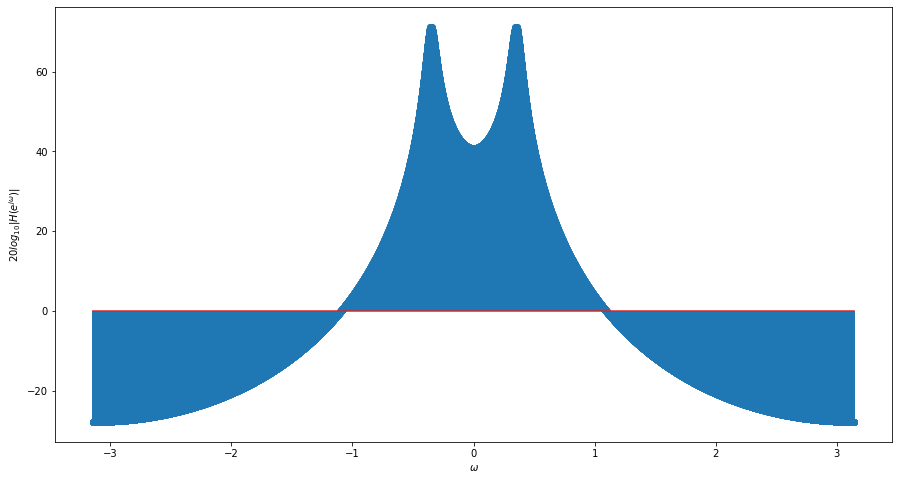

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
plt.stem(w,db_mag_h_z, use_line_collection = True)
plt.xlabel('$\omega$')
plt.ylabel('$20log_{10}|H(e^{j\omega})|$')

>### <font color='green'> Impulse Respone, h[n]


Text(0, 0.5, 'h[n]')

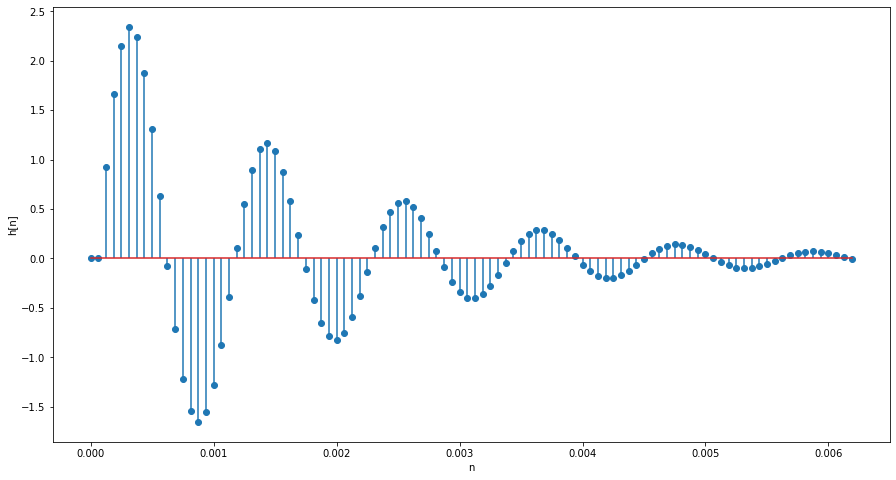

In [8]:
h = np.fft.ifft(np.fft.fftshift(H_z))
n = np.linspace(0,0.5,N)
plt.figure(figsize = (15,8))
plt.stem(n[0:100],h.real[0:100],use_line_collection=True) # Plotting the real values only
plt.xlabel('n')
plt.ylabel('h[n]')

>### <font color='dodgerblue'> Observations

Since the system has two conjugate symmetric poles in the Z-transform thus we were expecting the waveform to be that of a decaying sinusioid, which is observed. Also in the magnitude spectrum, we can see the spike corresponding to the formant frequency of the single formant resonator at 900 Hz.

Also, I am computing the N point FFT inorder to show the magnitude response. For the value of N=301, i.e 301 samples in the frequency response, the corresponding signal in time domain, has lesser time domain aliasing, and can imitate the desired impulse response well. I will be using the same value of N for computing the IFFT, to obtain the impulse response here, as well as in subsequent questions. 

# Question 2

Excite the above resonator (“filter”) with a periodic source excitation of F0 = 140 Hz. You can approximate the source signal by a narrow-triangular pulse train. Compute the output of the source-filter system over the duration of 0.5 second using the difference equation implementation of the LTI system.  Plot the time domain waveform over a few pitch periods so that you can observe waveform characteristics.  Play out the 0.5 sec duration sound and comment on the sound quality.

>### <font color='green'> Excitation

In order to generate the triangular pulse excitation of frequency $F_{0}$, we will need two fundamental signals:

* Impulse Train with frequency $F_{0}$
* Triangular Pulse

The convolution of both the sequences will give us the desired triangular pulse train.

Now, let's synthesize them one by one.



In [9]:
# defining the helper functions we need

def u(n,n_0): # Unit Step Function
  buffer = np.zeros_like(n)
  buffer[n>=n_0] = 1
  return buffer

def rect(n,a,b): # Rect function
  return u(n,a) - u(n,b)


>>Impulse Train

Here,  we have created a function to find the impulse train sequence, given the duration of the sound, the frequency of the glottal pulse ($F_{0}$) and the sampling rate ($F_{s}$).

In [11]:
# Function for computing impulse train Sequence
def impulse_seq(fs,F_0,duration): 
  samples = int(fs*duration)
  n = np.linspace(0,duration,samples) # sequence with 8000 samples
  impulse_train = np.zeros_like(n) 
  period = int(fs/F_0)
  for i in range(len(n)):
    if(i%period == 0):
      impulse_train[i] = 1

  return impulse_train

The sampling frequency in question 1 was given to be 16 kHz, since the duration of our signal is 0.5 secs, thus we will have 8000 samples in our excitation signal as well

In [12]:
# sequence with 8000 samples
n = np.linspace(0,0.5,8000)
impulse_train = impulse_seq(16000,140,0.5)

Text(0, 0.5, '$\\sum \\delta[n-k]$')

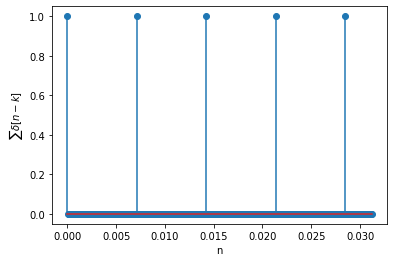

In [13]:
# Plotting some 500 samples of the impulse train
plt.stem(n[0:500],impulse_train[0:500],use_line_collection=True)
plt.xlabel('n')
plt.ylabel('$\sum \delta[n-k]$')

>> Triangular Pulse

We can get the traingular pulse by convolving two rect functions in time domain. The width of the rect functions should be half of the desired length of the triangular function. A scaling factor equal to the width of the rect signal needs to be divided to bring the range of the triangular pulse in [0,1]

In [14]:
# Function to calculate traingular pulse train using convolution of two rectangular sequences
def traingular_pulse_seq(fs,N,a,b):
  n = np.linspace(-(N//2)/(fs),(N//2)/(fs),N)
  r1 = rect(n,a/fs,b/fs)
  triangular_pulse = (1/(b-a))*np.convolve(r1,r1,mode='same')
  return triangular_pulse

Text(0, 0.5, 'T[n]')

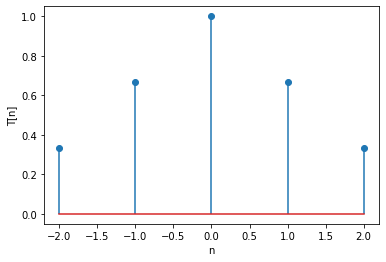

In [15]:
n = np.linspace(-2,2,5)
triangular_pulse = traingular_pulse_seq(1,5,-1,2)
plt.stem(n,triangular_pulse,use_line_collection=True)
plt.xlabel('n')
plt.ylabel('T[n]')

>> Triangular Pulse Train

Now that we have the triangular pulse and the impulse train, we can get the desired source excitation, i.e the triangular pulse by convolving the two together

Text(0, 0.5, 'triangular_pulse[n]')

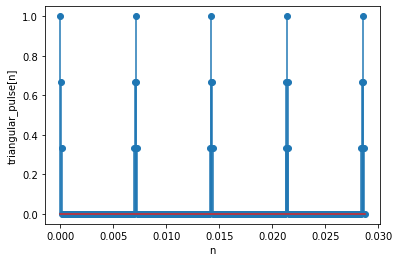

In [16]:
triangular_pulse_train = np.convolve(impulse_train,triangular_pulse,mode='same')

n = np.linspace(0,0.5,8000)

# Plotting 5 cycles of the triangular pulse 
plt.stem(n[0:460], triangular_pulse_train[0:460],use_line_collection=True)
plt.xlabel('n')
plt.ylabel('triangular_pulse[n]')

>### <font color='green'> Output

To find the output to the input triangular pulse exciation to the single formant resonator, we convolve the triangular_pulse, x[n] with the impulse response h[n] of the single formant resonator

thus output, y[n] = x[n]*h[n]

we will also plot y[n] for some cycles

In [17]:
# Convolving this with h[n]
output = np.convolve(triangular_pulse_train,h.real,mode='same')

Text(0, 0.5, 'y[n]')

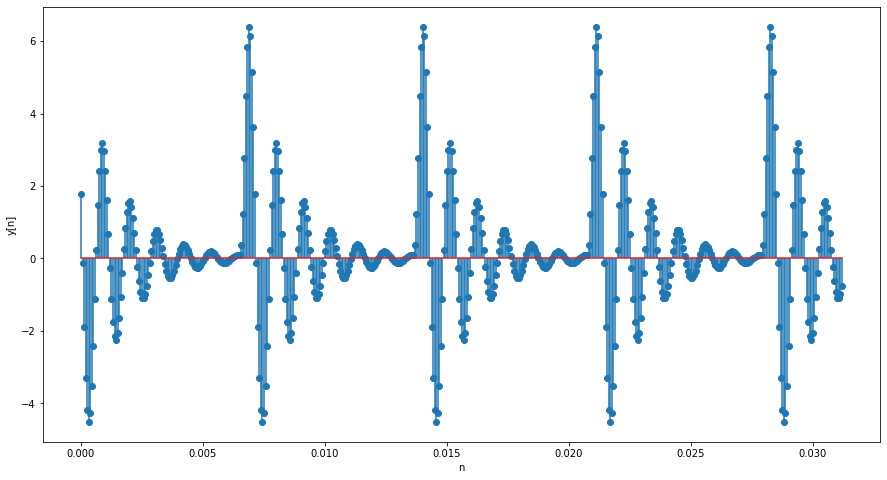

In [18]:
plt.figure(figsize = (15,8))
plt.stem(n[0:500],output[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y[n]')

>### <font color='green'> Audio Sequence

In [19]:
import scipy
from scipy.io.wavfile import read,write

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q2.wav'
write(filename, 16000, output.astype('int8'))

In [20]:
import IPython
IPython.display.Audio(filename)

>### <font color='dodgerblue'> Observations:

As per my observation, we can hear a sound which is analogous to a periodic beep. If we close our mouth and "humm" by only vibrating our vocal tract, we can produce a sound which is similar to the generated sound. We can also say |^| (अ sound in Hindi)

# Question 3

Vary the parameters as indicated below; plot and comment on the differences in waveform and in sound quality for the different parameter combinations. 


(a)F0 = 120 Hz, F1 = 300 Hz, B1 = 100 Hz\
(b)F0 = 120 Hz, F1=1200 Hz, B1 = 200 Hz\
(c)F0 = 180 Hz, F1 = 300 Hz, B1 = 100 Hz

>>#### <font color='green'> Function for $H(z)$ from Q1

From Q1, we can get H(z) as

In [21]:
def H(z,K,F_i,B_i,F_s):
  theta = 2*np.pi*F_i*(1/F_s)
  r = np.exp(B_i*np.pi*(1/F_s))
  z0 = cmath.rect(r,theta)
  z1 = cmath.rect(r,-theta)
  return K/((1 - z0*z**(-1))*(1 - z1*z**(-1)))

>### <font color='green'> (a) F0 = 120 Hz, F1 = 300 Hz, B1 = 100 Hz

>>#### $h_{a}[n]$ (subscript a corresponds to a part of the question)

Text(0, 0.5, '$h_{a}[n]$')

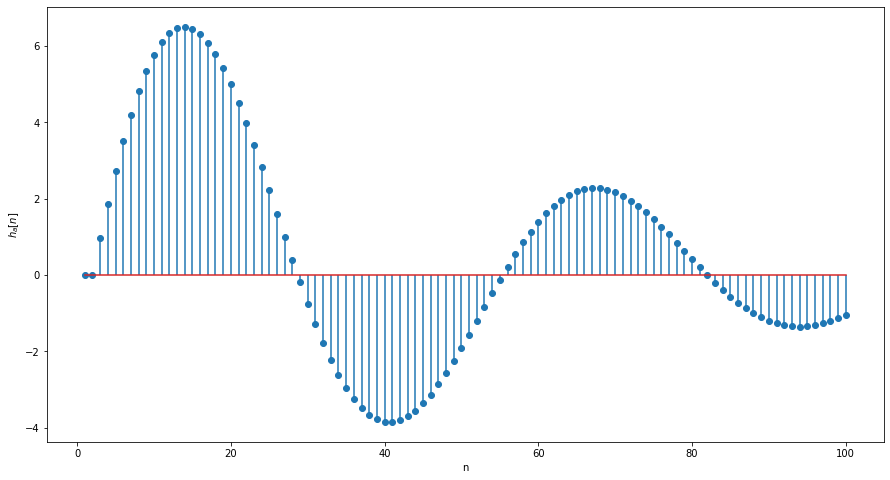

In [23]:
# The impulse response corresponding to the single formant resonator

N = 8000
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w))
H_za = list(map(lambda x: H(x,1,300,100,16000), z))

ha = np.fft.ifft(np.fft.fftshift(H_za))
n = np.linspace(1,N,N)
plt.figure(figsize = (15,8))
plt.stem(n[0:100],ha.real[0:100],use_line_collection=True) # Plotting the real values only
plt.xlabel('n')
plt.ylabel('$h_{a}[n]$')

>>#### Excitation Signal ($x_{a}[n]$)

In [24]:
# taking helper functions from question 2
def impulse_seq(fs,F_0,duration): # function for computing impulse train
  samples = int(fs*duration)
  n = np.linspace(0,duration,samples) # sequence with 8000 samples
  impulse_train = np.zeros_like(n) 
  period = int(fs/F_0)# Impulse Train sequence
  for i in range(len(n)):
    if(i%period == 0):
      impulse_train[i] = 1

  return impulse_train

def traingular_pulse_seq(fs,N,a,b):
  n = np.linspace(-(N//2)/(fs),(N//2)/(fs),N)
  r1 = rect(n,a/fs,b/fs)
  triangular_pulse = (1/(b-a))*np.convolve(r1,r1,mode='same')
  return triangular_pulse

In [25]:
impulse_train = impulse_seq(16000,120,0.5)
triangular_pulse = traingular_pulse_seq(16000,5,-1,2)
triangular_pulse_train = np.convolve(impulse_train,triangular_pulse,mode='same')

>>#### Output: $y_{a}[n] = x_{a}[n]*h_{a}[n]$

In [26]:
output_a = np.convolve(triangular_pulse_train,ha.real,mode='same')

Text(0, 0.5, '$y_{a}[n]$')

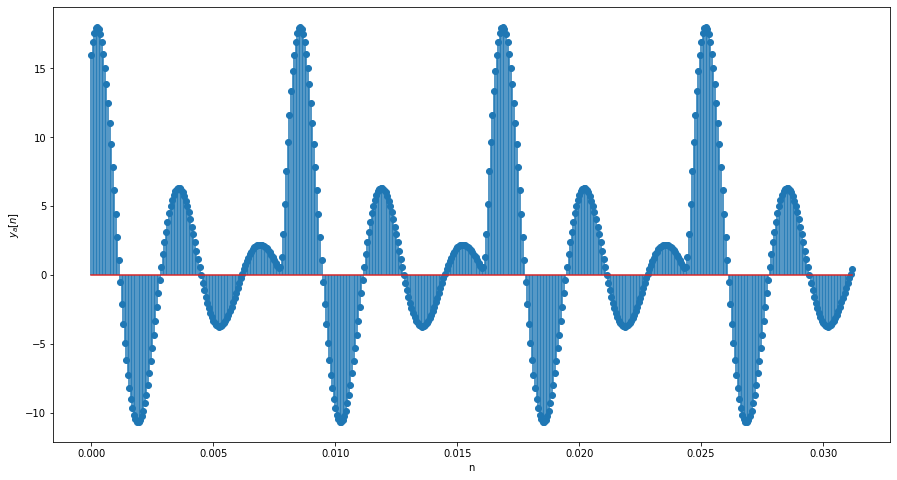

In [27]:
n = np.linspace(0,0.5,8000)
plt.figure(figsize = (15,8))
plt.stem(n[0:500],output_a[0:500],use_line_collection=True)
plt.xlabel('n')
plt.ylabel('$y_{a}[n]$')

In [28]:
import scipy
from scipy.io.wavfile import read,write

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q3_a.wav'
write(filename, 16000, output_a.astype('int8'))

>>#### Audio

In [29]:
import IPython
IPython.display.Audio(filename)

>### <font color='green'> (b) F0 = 120 Hz, F1=1200 Hz, B1 = 200 Hz

>>#### $h_{b}[n]$ (subscript a corresponds to a part of the question)

Text(0, 0.5, '$h_{b}[n]$')

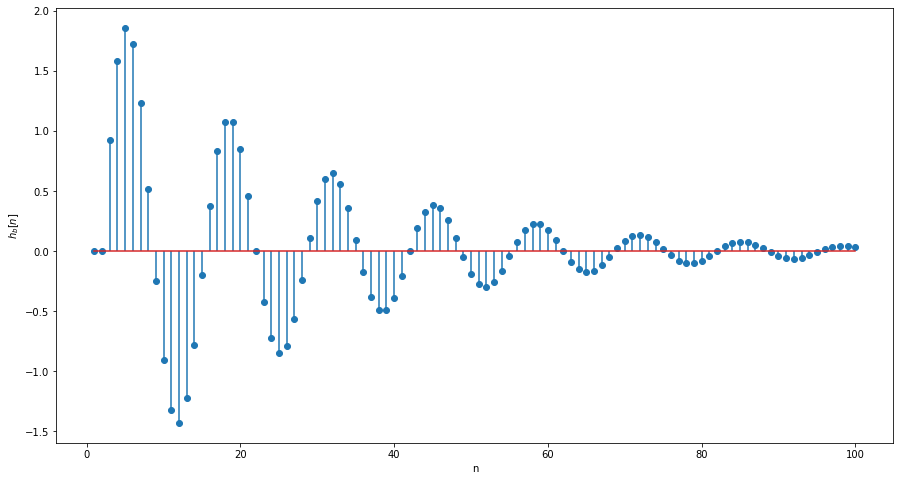

In [31]:
N = 8000
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w))
H_zb = list(map(lambda x: H(x,1,1200,200,16000), z))

hb = np.fft.ifft(np.fft.fftshift(H_zb))
n = np.linspace(1,N,N)
plt.figure(figsize = (15,8))
plt.stem(n[0:100],hb.real[0:100],use_line_collection=True) # Plotting the real values only
plt.xlabel('n')
plt.ylabel('$h_{b}[n]$')

>>#### Excitation Signal ($x_{b}[n]$)

In [32]:
# taking helper functions from question 2
def impulse_seq(fs,F_0,duration): # function for computing impulse train
  samples = int(fs*duration)
  n = np.linspace(0,duration,samples) # sequence with 8000 samples
  impulse_train = np.zeros_like(n) 
  period = int(fs/F_0)# Impulse Train sequence
  for i in range(len(n)):
    if(i%period == 0):
      impulse_train[i] = 1

  return impulse_train

def traingular_pulse_seq(fs,N,a,b):
  n = np.linspace(-(N//2)/(fs),(N//2)/(fs),N)
  r1 = rect(n,a/fs,b/fs)
  triangular_pulse = (1/(b-a))*np.convolve(r1,r1,mode='same')
  return triangular_pulse

In [33]:
impulse_train = impulse_seq(16000,120,0.5)
triangular_pulse = traingular_pulse_seq(16000,5,-1,2)
triangular_pulse_train = np.convolve(impulse_train,triangular_pulse,mode='same')

>>#### Output: $y_{b}[n] = x_{b}[n]*h_{b}[n]$

In [34]:
output_b = np.convolve(triangular_pulse_train,hb.real,mode='same')

Text(0, 0.5, '$y_{b}[n]$')

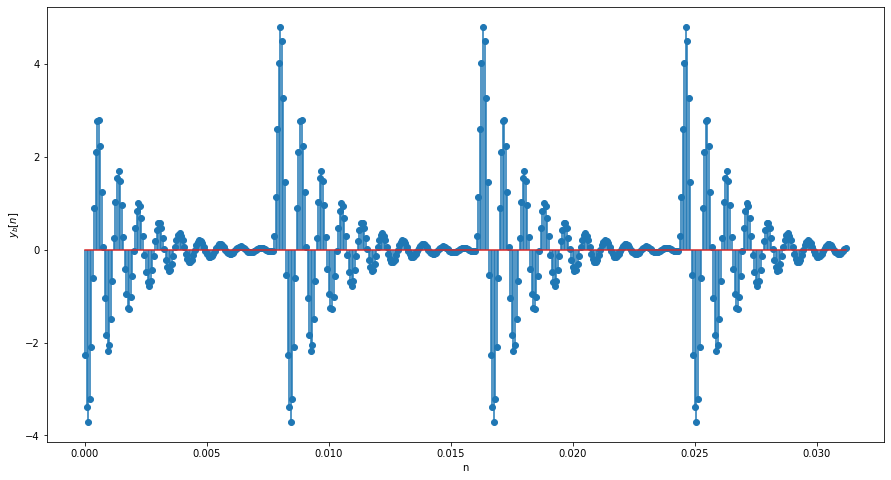

In [35]:
n = np.linspace(0,0.5,8000)
plt.figure(figsize = (15,8))
plt.stem(n[0:500],output_b[0:500],use_line_collection=True)
plt.xlabel('n')
plt.ylabel('$y_{b}[n]$')

In [40]:
import scipy
from scipy.io.wavfile import read,write

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q3_b.wav'
write(filename, 16000, output_b.astype('uint8'))

>>#### Audio

In [41]:
import IPython
IPython.display.Audio(filename)

>### <font color='green'> (c) F0 = 180 Hz, F1 = 300 Hz, B1 = 100 Hz

>>#### Impulse Response: $h_{c}[n]$

Text(0, 0.5, '$h_{c}[n]$')

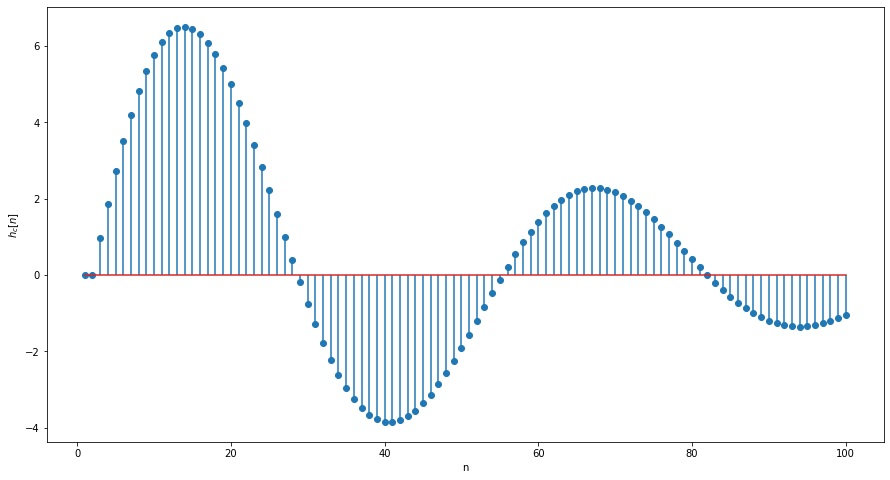

In [43]:
# The impulse response corresponding to the single formant resonator
N = 8000 
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w))
H_zc = list(map(lambda x: H(x,1,300,100,16000), z))

hc = np.fft.ifft(np.fft.fftshift(H_zc))
n = np.linspace(1,N,N)
plt.figure(figsize = (15,8))
plt.stem(n[0:100],hc.real[0:100],use_line_collection=True) # Plotting the real values only
plt.xlabel('n')
plt.ylabel('$h_{c}[n]$')

>>#### Excitation Signal $x_{c}[n]$

In [44]:
# taking helper functions from question 2
def impulse_seq(fs,F_0,duration): # function for computing impulse train
  samples = int(fs*duration)
  n = np.linspace(0,duration,samples) # sequence with 8000 samples
  impulse_train = np.zeros_like(n) 
  period = int(fs/F_0)# Impulse Train sequence
  for i in range(len(n)):
    if(i%period == 0):
      impulse_train[i] = 1

  return impulse_train

def traingular_pulse_seq(fs,N,a,b):
  n = np.linspace(-(N//2)/(fs),(N//2)/(fs),N)
  r1 = rect(n,a/fs,b/fs)
  triangular_pulse = (1/(b-a))*np.convolve(r1,r1,mode='same')
  return triangular_pulse

In [45]:
impulse_train = impulse_seq(16000,180,0.5)
triangular_pulse = traingular_pulse_seq(16000,5,-1,2)
triangular_pulse_train = np.convolve(impulse_train,triangular_pulse,mode='same')

>>#### Output: $y_{c}[n] = x_{c}[n]*h_{c}[n]$

In [46]:
output_c = np.convolve(triangular_pulse_train,hc.real,mode='same')

Text(0, 0.5, '$y_{c}[n]$')

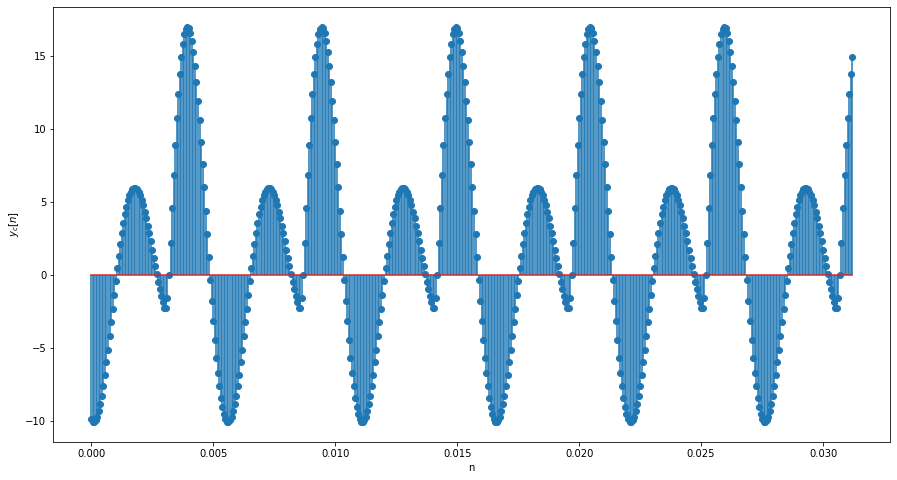

In [47]:
n = np.linspace(0,0.5,8000)
plt.figure(figsize = (15,8))
plt.stem(n[0:500],output_c[0:500],use_line_collection=True)
plt.xlabel('n')
plt.ylabel('$y_{c}[n]$')

In [52]:
import scipy
from scipy.io.wavfile import read,write

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q3_c.wav'
write(filename, 16000, output_c.astype('int8'))

>>#### Audio

In [53]:
import IPython
IPython.display.Audio(filename)

>### <font color='dodgerblue'> Observations

The three parts of the question demonstrate, how the perception of sounds change upon changing the controlling parameters of our single formant resonator. Taking the synthesized audio in part (a) as reference, the audio in part (b) appears to be noisy, and is more baser thus sounding a little nasal. The audio in part (a) is comparatively flat sounding.

The audio in part (c), sounds much different. The most noticable difference is the higher pitch, compared to that of part (a) and (b).

# Question 4

In place of the simple single-resonance signal, synthesize the following more realistic vowel sounds at two distinct pitches (F0 = 120 Hz, F0 = 220 Hz). Keep the bandwidths constant at 100 Hz for all formants. Duration of sound: 0.5 sec. Comment on the sound quality across the different sounds. Plot a few periods of any 2 examples

Vowel F1, F2, F3\
\
**/a/** 730, 1090, 2440\
**/i/** 270, 2290, 3010\
**/u/** 300, 870, 2240 

>### <font color='green'> Helper Functions

In [54]:
# Helper functions

import numpy as np
import cmath
import matplotlib.pyplot as plt

# Unit Step Function
def u(n,n_0):
  buffer = np.zeros_like(n)
  buffer[n>=n_0] = 1
  return buffer


# Rect function
def rect(n,a,b):
  return u(n,a) - u(n,b)


# Impulse Train
def impulse_seq(fs,F_0,duration):
  samples = int(fs*duration)
  n = np.linspace(0,duration,samples) # sequence with 8000 samples
  impulse_train = np.zeros_like(n) 
  period = int(fs/F_0)# Impulse Train sequence
  for i in range(len(n)):
    if(i%period == 0):
      impulse_train[i] = 1

  return impulse_train
  

# Single Triangular Pulse
def traingular_pulse_seq(fs,N,a,b):
  n = np.linspace(-(N//2)/(fs),(N//2)/(fs),N)
  r1 = rect(n,a/fs,b/fs)
  triangular_pulse = (1/(b-a))*np.convolve(r1,r1,mode='same')
  return triangular_pulse


# Z-transform for Single formant Resonator
def H(z,K,F_i,B_i,F_s):
  theta = 2*np.pi*F_i*(1/F_s)
  r = np.exp(B_i*np.pi*(1/F_s))
  z0 = cmath.rect(r,theta)
  z1 = cmath.rect(r,-theta)
  return K/((1 - z0*z**(-1))*(1 - z1*z**(-1)))

>### <font color='green'> Excitations : $x_{1}[n]$ and $x_{2}[n]$

Since the excitation consists of two distinct pitches thus we basically have two excitations one with frequency 120 Hz and another with frequency 220 Hz

In [55]:
# Creating the two excitations
n = np.linspace(0,0.5,8000)

# Impulse train sequences for frequency 120 and 220 Hz
impulse_train1 = impulse_seq(16000,120,0.5)
impulse_train2 = impulse_seq(16000,220,0.5)

# triangular pulse of 5 samples
triangular_pulse = traingular_pulse_seq(1,5,-1,2)

# Triangular pulse trains for frequency 120 and 220 Hz
triangular_pulse_train1 = np.convolve(impulse_train1,triangular_pulse,mode='same')
triangular_pulse_train2 = np.convolve(impulse_train2,triangular_pulse,mode='same')

>### <font color='green'> Formant frequencies in **/a/** are 730, 1090, 2440. Calculating the response of the combined resonator system for the excitations $x_{1}[n]$ and $x_{2}[n]$



>>#### $H_{/a/}(z)_{z=e^{j\omega}}$ (here /a/ refers to the vowel sound /a/)

In [66]:
N = 8001
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w))

H_z1 = list(map(lambda x: H(x,1,730,100,16000), z))
H_z2 = list(map(lambda x: H(x,1,1090,100,16000), z))
H_z3 = list(map(lambda x: H(x,1,2440,100,16000), z))

H_za = np.multiply(np.multiply(H_z1,H_z2),H_z3)

>>#### Impulse Response: $h_{/a/}[n]$

In [67]:
h_a = np.fft.ifft(np.fft.fftshift(H_za))

>>#### Output: $y_{a}[n]$ = $h_{a}[n]$ * $x[n]$ for both $x_1{n}$ and $x_{2}[n]$

In [68]:
y_a1 = np.convolve(triangular_pulse_train1,h_a.real,mode="same")
y_a2 = np.convolve(triangular_pulse_train2,h_a.real,mode="same")

Text(0, 0.5, 'y_a2[n]')

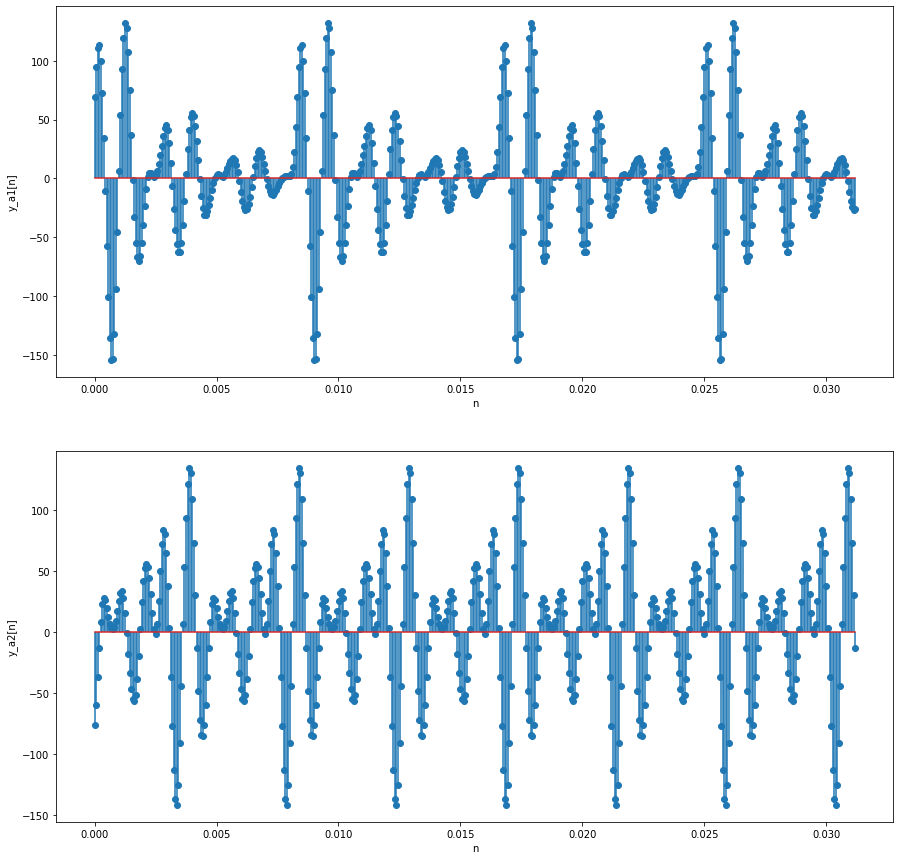

In [69]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.stem(n[0:500],y_a1[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y_a1[n]')
plt.subplot(2,1,2)
plt.stem(n[0:500],y_a2[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y_a2[n]')

>>#### Audio files corresponding to frequencies 120Hz and 200 Hz 

In [70]:
import scipy
from scipy.io.wavfile import read,write
import IPython

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q4_a_120.wav'
write(filename, 16000, y_a1.astype('int8'))
IPython.display.Audio(filename)

In [61]:
filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q4_a_220.wav'
write(filename, 16000, y_a2.astype('int8'))
IPython.display.Audio(filename)

>### <font color='green'> For the formant frequencies in **/i/** are 270, 2290, 3010. Thus the impulse response for the sequence would be a combined resonator for all the three frequencies



>>#### $H_{/i/}(z)_{z=e^{j\omega}}$ (here /i/ refers to the vowel sound /i/)

In [71]:
N = 8001
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w))

H_z1 = list(map(lambda x: H(x,1,270,100,16000), z))
H_z2 = list(map(lambda x: H(x,1,2290,100,16000), z))
H_z3 = list(map(lambda x: H(x,1,3010,100,16000), z))

H_zi = np.multiply(np.multiply(H_z1,H_z2),H_z3)

>>#### Impulse Response: $h_{/i/}[n]$

In [72]:
h_i = np.fft.ifft(np.fft.fftshift(H_zi))

>>#### Output $y_{/i/}[n]$  = $h_{/i/}[n]$ * $x[n]$ for both $x_1{n}$ and $x_{2}[n]$

In [73]:
y_i1 = np.convolve(triangular_pulse_train1,h_i.real,mode="same")
y_i2 = np.convolve(triangular_pulse_train2,h_i.real,mode="same")

Text(0, 0.5, 'y_i2[n]')

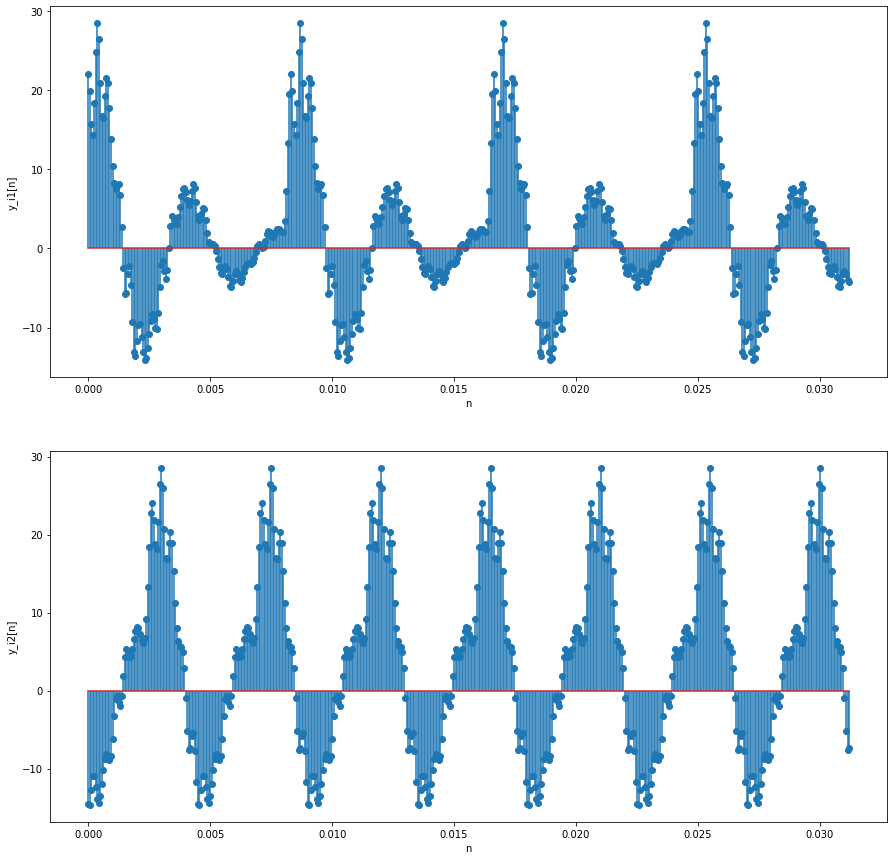

In [74]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.stem(n[0:500],y_i1[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y_i1[n]')
plt.subplot(2,1,2)
plt.stem(n[0:500],y_i2[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y_i2[n]')

>>#### Audio files coresponding to frequencies 120 and 200 Hz 

In [75]:
import scipy
from scipy.io.wavfile import read,write
import IPython

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q4_i_120.wav'
write(filename, 16000, y_i1.astype('int8'))
IPython.display.Audio(filename)

In [76]:
filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q4_i_220.wav'
write(filename, 16000, y_i2.astype('int8'))
IPython.display.Audio(filename)

>### <font color='green'> For the formant frequencies in **/u/** are 300, 870, 2240. Thus the impulse response for the sequence would be a combined resonator for all the three frequencies



>>#### $H_{/u/}(z)_{z=e^{j\omega}}$ (here /u/ refers to the vowel sound /u/)

In [89]:
N = 8001 
w = np.linspace(-np.pi, np.pi, N) 
z = list(map(lambda x: cmath.rect(1,-x), w))

H_z1 = list(map(lambda x: H(x,1,300,100,16000), z))
H_z2 = list(map(lambda x: H(x,1,870,100,16000), z))
H_z3 = list(map(lambda x: H(x,1,2240,100,16000), z))

H_zu = np.multiply(np.multiply(H_z1,H_z2),H_z3)

>>#### Impulse Response $h_{u}[n]$

In [90]:
h_u = np.fft.ifft(np.fft.fftshift(H_zu))

>>#### Output $y_{/u/}[n]$  = $h_{/u/}[n]$ * $x[n]$ for both $x_1{n}$ and $x_{2}[n]$

In [91]:
y_u1 = np.convolve(triangular_pulse_train1,h_u.real,mode="same")
y_u2 = np.convolve(triangular_pulse_train2,h_u.real,mode="same")

Text(0, 0.5, 'y_u2[n]')

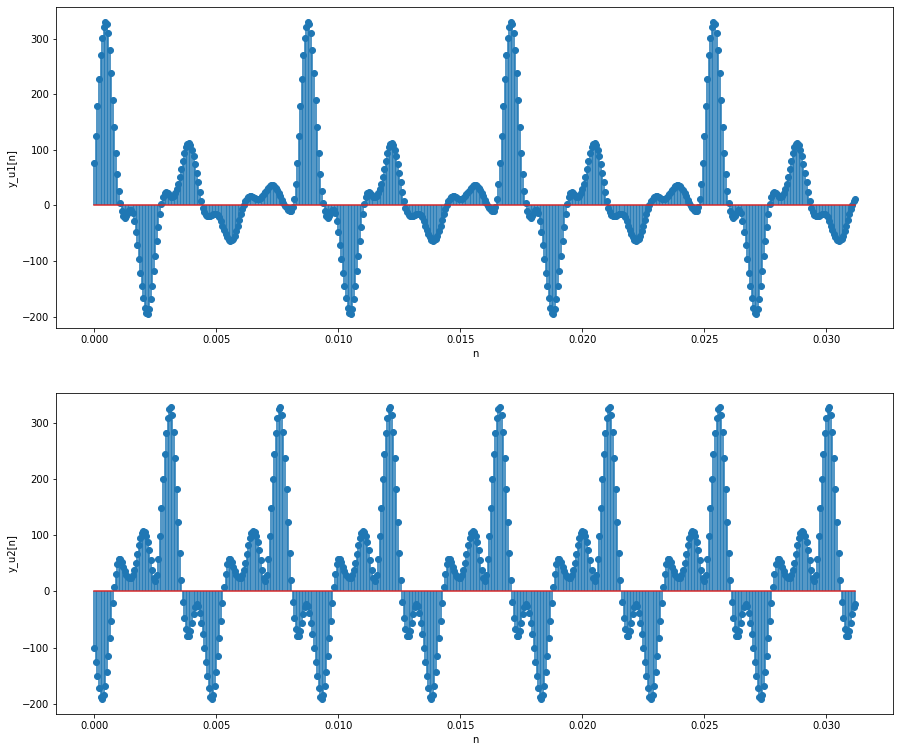

In [92]:
plt.figure(figsize=(15,13))
plt.subplot(2,1,1)
plt.stem(n[0:500],y_u1[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y_u1[n]')
plt.subplot(2,1,2)
plt.stem(n[0:500],y_u2[0:500], use_line_collection=True) #Plotting some cycles
plt.xlabel('n')
plt.ylabel('y_u2[n]')

>>#### Audio files coresponding to frequencies 120 and 200 Hz 

In [93]:
import scipy
from scipy.io.wavfile import read,write
import IPython

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q4_u_120.wav'
write(filename, 16000, y_u1.astype('int8'))
IPython.display.Audio(filename)

In [94]:
filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/q4_u_220.wav'
write(filename, 16000, y_u2.astype('int8'))
IPython.display.Audio(filename)

>### <font color='dodgerblue'> Observations

The output corresponding to each of the sound /a/, /i/ and /u/, are different from each other in terms of the production and articulatory aspect. The sounds which are produced with the 120 Hz excitation are easily to match our sounds with, but difficult with the 220 Hz excitation. Also, it is easier to observe the difference in the percieved sounds for the excitation of 120 Hz but not with 220 Hz, if listened closely only then we can distinguish between the sounds at 220  Hz. 

For the same excitation, the difference in the sounds is noticable when we try to mimic producing a similar sound while playing the audio. Since the articulation also plays a major role in shaping the sound as it is percieved by humans, the distinction is very hard to catch but still it is there. The source filter model, can aptly simulate this difference in perception which is amazing owing to the complexity and sophistication of our speech system.

Converting the Notebook to HTML format

In [ ]:
!pip install nbconvert

In [ ]:
%cd '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1'

/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1


In [ ]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/Speech_Processing_Assignment 1.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/Speech_Processing_Assignment 1.ipynb to html
[NbConvertApp] Writing 918840 bytes to /content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 1/Speech_Processing_Assignment 1.html
